In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Jan 16 14:55:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   49C    P2    80W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 32%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.resblock_encoder import Encoder
from model.latent_layer.normal_to_discrete_lse_latent_layer import LatentLayer
from model.decoder.resblock_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
def get_kl(M, N, k, post_sigma, elem_sigma, prior_sigma=1.0):
    # z : (M, z)
    # mu : (N, z)
    
    z = torch.randn(M, k).cuda() * prior_sigma
    mu = torch.randn(N, k).cuda() * post_sigma
            
    # (M, N) = sum((M, 1, z) - (1, N, z), dim=2)
    distance = torch.norm(z.unsqueeze(1) - mu.unsqueeze(0), dim=2) ** 2
    alpha = -1/(2*elem_sigma**2)
    loss = -torch.mean(torch.logsumexp(alpha*distance, dim=1), dim=0)
    loss = loss + 0.5*k*(2*np.log(elem_sigma)-np.log(np.e)) + np.log(N)
    
    return loss.item()

from tqdm import tqdm

M = 1024
N = 256
k = 2
post_sigma = 1
elem_log_sigmas = np.arange(-10, 10, 0.01)

losses_list = []
for _ in tqdm(range(100)):
    losses = np.array([get_kl(M, N, k, post_sigma, np.exp(elem_log_sigma)) for elem_log_sigma in elem_log_sigmas])
    losses_list.append(losses)
    
losses = np.median(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

losses = np.mean(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

100%|█████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]

0.4819089900901072 -0.7300000000001977
0.48675225595987537 -0.7200000000001977


In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.n_blocks = 2
hp.n_embeddings = 10
hp.init_log_sigma = -0.72
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 59.36157989501953
encoder.downs 5.989013671875
encoder.blocks 53.35693359375
encoder.linear 0.01563262939453125
latent_layer 8.0108642578125e-05
decoder 19.359989166259766
decoder.linear 0.0234375
decoder.ups 5.9820556640625
decoder.blocks 13.31787109375
decoder.out_conv 0.036624908447265625
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.16-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 488152
-rw-rw-r-- 1 scpark scpark   1002788  1월 16 14:55 events.out.tfevents.1705382672.GPUSVR01
-rw-rw-r-- 1 scpark scpark 248146041  1월 16 14:54 save_10000
-rw-rw-r-- 1 scpark scpark 248135677  1월 16 14:24 save_0
-rw-rw-r-- 1 scpark scpark    143876  1월 16 14:22 events.out.tfevents.1705382250.GPUSVR01
-rw-rw-r-- 1 scpark scpark     48260  1월 16 14:17 events.out.tfevents.1705382137.GPUSVR01
-rw-rw-r-- 1 scpark scpark     12356  1월 16 14:15 events.out.tfevents.1705382071.GPUSVR01
-rw-rw-r-- 1 scpark scpark     33956  1월 16 14:14 events.out.tfevents.1705381999.GPUSVR01
-rw-rw-r-- 1 scpark scpark    647740  1월 16 14:13 events.out.tfevents.1705380810.GPUSVR01
-rw-rw-r-- 1 scpark scpark    400772  1월 16 13:51 events.out.tfevents.1705380355.GPUSVR01
-rw-rw-r-- 1 scpark scpark   1263428  1월 16 13:45 events.out.tfevents.1705379115.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

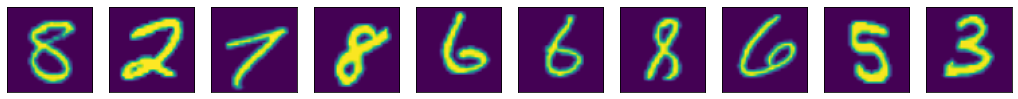

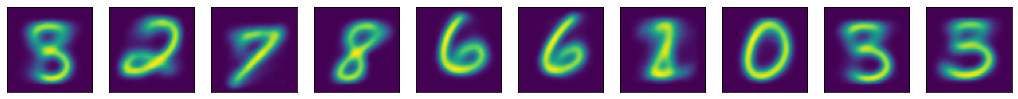

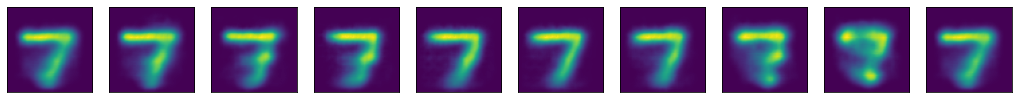

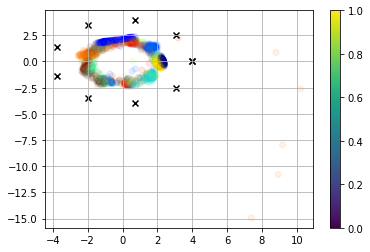

10501
lse_loss 0.3597726821899414
recon_loss 0.13067591190338135
10502
lse_loss 0.30754852294921875
recon_loss 0.13094794750213623
10503
lse_loss 0.43492603302001953
recon_loss 0.13711632788181305
10504
lse_loss 0.32610416412353516
recon_loss 0.14092013239860535
10505
lse_loss 0.46226024627685547
recon_loss 0.1262757033109665
10506
lse_loss 0.4119253158569336
recon_loss 0.12880437076091766
10507
lse_loss 0.40151023864746094
recon_loss 0.1308232545852661
10508
lse_loss 0.4122753143310547
recon_loss 0.13385522365570068
10509
lse_loss 0.4735703468322754
recon_loss 0.13981138169765472
10510
lse_loss 0.40728092193603516
recon_loss 0.1379077136516571
10511
lse_loss 0.42554378509521484
recon_loss 0.13512678444385529
10512
lse_loss 0.4062232971191406
recon_loss 0.13113188743591309
10513
lse_loss 0.4684638977050781
recon_loss 0.12876813113689423
10514
lse_loss 0.4334440231323242
recon_loss 0.13006240129470825
10515
lse_loss 0.42047929763793945
recon_loss 0.12545786798000336
10516
lse_loss 0.338

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            temperature = linear(1, 1e-2, step, 0, 20*1000)
            data = model(data, M=1024, temperature=temperature)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 100 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()

            batch = next(iter(test_loader))
            data = preprocess(batch)

            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024, temperature=1)

            plot(data['x'])
            plot(data['y'])

            with torch.no_grad():
                z = model_list[0].latent_layer.embeddings
                y = model.sample(z)
                plot(y)

            import matplotlib.pyplot as plt
            _e = model_list[0].latent_layer.embeddings.data.cpu().numpy()
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.1)
            plt.scatter(_e[:, 0], _e[:, 1], marker='x', color='black')
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=1024, temperature=1)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = model_list[0].latent_layer.embeddings
    y = model.sample(z)
    plot(y)

import matplotlib.pyplot as plt
_e = model_list[0].latent_layer.embeddings.data.cpu().numpy()
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.1)
plt.scatter(_e[:, 0], _e[:, 1], marker='x', color='black')
plt.grid()
plt.colorbar()
plt.show()